# Turma #867   -   Projeto Machine Learning II (parte I - Desenvolvimento)
## Grupo de trabalho:
- Adriana Roberta Miceli de Souza <br/>
- Debora Kassem Buturi <br/>
- Helen Cristina de Acypreste Rocha <br/> 
- Marcus Fontes <br/>
- Richard Raphael Banak <br/>

## Deadline

10/out/2022

## Entrega

Enviar um único email com nome dos participantes do projeto para:

- rychard.guedes@ada.tech

## Contextualização
A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que discrimine ao máximo os bons pagadores dos maus pagadores. Para isso, foi disponibilizada uma base de dados com milhares de casos de empréstimos do passado com diversas características dos clientes. Devem ser entregues um modelo. Por questões contratuais, o pagamento será realizado baseado no desempenho (ROC AUC) do modelo ao longo do tempo.

## Highlights

- Vamos continuar utilizando as bases do módulo passado, todo o progresso até aqui será mantido.
- Por enquanto, continuaremos apenas com `application_train.csv` e `application_test_student.csv`.
- Vamos começar a olhar para performance! Lembrem-se de olhar sempre para **ROC AUC**.

## Base de Dados
Serão utilizadas bases de dados com informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes. O conjunto de dados está dividido em treino e teste, todos no formato csv. Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de treino, subdividindo tal base como a squad achar melhor. Existe também os das variáveis explicativas, para ajudar no desenvolvimento do projeto. Serão necessários diversos cruzamentos e vocês estão livres para usar os dados da maneira que acharem mais conveniente.

[Baixar](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view?usp=sharing)

## Entregáveis

- Dois notebooks: (i) com a investigação e comparações feitas; (ii) com o fluxo limpo do modelo escolhido.
- Crie pipeline para o modelo.
- Realize processo de otimização dos hiperparâmetros.
- Utilize pelo menos uma variável categórica e pelo menos uma variável numérica.
- Para garantir robustez, adicione uma camada de imputação de missing para todas as features. Reflita sobre qual é a melhor estratégia para cada uma das variáveis explicativas.
- Não foque mais em utilizar apenas 5 variáveis, vamos abrir os horizontes e buscar outras features que podem ser úteis. Vale salientar que a depender do modelo, não adianta simplesmente colocar todas porque isso pode gerar problemas de overfitting, de underfitting ou de eficiência computacional, então será necessário fazer algum tipo de seleção.
- Apenas um modelo será entregue. Faça a escolha baseando-se em performance, mas levando em consideração custo computacional. Descreva o processo de decisão e argumente a favor do modelo - deve estar dentro do fluxo limpo, no notebook modelo escolhido, no início.
- Para marcar a previsão, use a probabilidade do evento (sem binarizar).
- **Meta em bater pelo menos 0.70 de AUC. Se não conseguir, não há problema, mas falar antecipadamente com Rychard/Bruno.**

# Imports

!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder,LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import xgboost as xgb

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

### 0. Leitura dos dados

In [4]:
caminho = './projeto_ml2/'
arquivo_principal = 'application_train.csv'
arquivo_oculto = 'application_test_student.csv'
arquivo_metadados = 'HomeCredit_columns_description.csv'

0.1 Inputs

In [5]:
df = pd.read_csv(f'{caminho}/{arquivo_principal}')

df_oculto = pd.read_csv(f'{caminho}/{arquivo_oculto}')

df_metadados = pd.read_csv(f'{caminho}/{arquivo_metadados}', encoding = 'Windows-1252')

- Avaliando as primeiras linhas

In [6]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


 * Avaliando o arquivo de metadados

In [7]:
df_metadados.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [8]:
df_metadados_ = df_metadados[df_metadados['Table'] =='application_{train|test}.csv']
df_metadados_[["Row", "Description"]]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


### 1. Entendimento inicial do dataset application_train

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 229.0+ MB


In [10]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,246008.000000,246008.000000,246008.000000,2.460080e+05,2.460080e+05,245998.000000,2.457820e+05,246008.000000,246008.000000,246008.000000,...,246008.000000,246008.000000,246008.000000,246008.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000,212836.000000
mean,278280.072908,0.081176,0.415527,1.689122e+05,5.996283e+05,27129.162648,5.389289e+05,0.020882,-16042.794393,63963.755699,...,0.007975,0.000589,0.000508,0.000289,0.006291,0.006944,0.034487,0.267403,0.264109,1.900040
std,102790.909988,0.273106,0.719922,2.603818e+05,4.030672e+05,14504.965232,3.699738e+05,0.013852,4365.973763,141400.318322,...,0.088948,0.024271,0.022536,0.016986,0.083236,0.109538,0.204179,0.916640,0.611269,1.868217
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189165.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16561.125000,2.385000e+05,0.010006,-19691.000000,-2758.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278392.500000,0.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,4.500000e+05,0.018850,-15763.000000,-1215.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367272.250000,0.000000,1.000000,2.025000e+05,8.086500e+05,34599.375000,6.795000e+05,0.028663,-12418.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,19.000000,23.000000


### 2. EDA - Avaliação inicial

2.0- Avaliação da variável resposta

In [11]:
df['TARGET'].value_counts() , df['TARGET'].value_counts(normalize=True) # Dados desbalanceados (Default próximo de 8%)

(0    226038
 1     19970
 Name: TARGET, dtype: int64,
 0    0.918824
 1    0.081176
 Name: TARGET, dtype: float64)

2.1- Avaliando o % de missing das possíveis variáveis de entrada:

In [12]:
percent_missing = df.isnull().sum() / len(df)
percent_missing

SK_ID_CURR                      0.000000
TARGET                          0.000000
NAME_CONTRACT_TYPE              0.000000
CODE_GENDER                     0.000000
FLAG_OWN_CAR                    0.000000
FLAG_OWN_REALTY                 0.000000
CNT_CHILDREN                    0.000000
AMT_INCOME_TOTAL                0.000000
AMT_CREDIT                      0.000000
AMT_ANNUITY                     0.000041
AMT_GOODS_PRICE                 0.000919
NAME_TYPE_SUITE                 0.004260
NAME_INCOME_TYPE                0.000000
NAME_EDUCATION_TYPE             0.000000
NAME_FAMILY_STATUS              0.000000
NAME_HOUSING_TYPE               0.000000
REGION_POPULATION_RELATIVE      0.000000
DAYS_BIRTH                      0.000000
DAYS_EMPLOYED                   0.000000
DAYS_REGISTRATION               0.000000
DAYS_ID_PUBLISH                 0.000000
OWN_CAR_AGE                     0.659974
FLAG_MOBIL                      0.000000
FLAG_EMP_PHONE                  0.000000
FLAG_WORK_PHONE 

In [13]:
tolerancia_missing = 0.1

var_missing= percent_missing[percent_missing >= tolerancia_missing].index

print("Tolerância para missing (% da coluna) =",tolerancia_missing*100,"%:")
print("Quantidade de variáveis com missing maior que a tolerância:", len(var_missing))
print("Quantidade total de variáveis:",len(df.columns))
print("% de Variáveis excluídas da análise:",np.round(len(var_missing)/len(df.columns)*100,1),"%")

var_missing

Tolerância para missing (% da coluna) = 10.0 %:
Quantidade de variáveis com missing maior que a tolerância: 57
Quantidade total de variáveis: 122
% de Variáveis excluídas da análise: 46.7 %


Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMEN

2.2- Classificação inicial das possíveis variáveis de entrada:

In [14]:
# string (tratar com getdummies as binárias, OE as não binárias e fazer imputmissing com moda usando SimpleImputer)
var_string_binaria = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_REALTY' ]
var_string_nao_binaria = [
    
'NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE'
,'WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE'
    
]

var_string = var_string_binaria + var_string_nao_binaria

# numéricas (tratar com normalizações Std ou minmax e fazer imputmissing com SimpleImputer)

var_num_discretas = ['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','HOUR_APPR_PROCESS_START']

var_num_continuas = [
    
 'CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE'
,'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS'
,'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'
,'DAYS_LAST_PHONE_CHANGE'

]

var_num_flag = [ 
    
    'REG_REGION_NOT_LIVE_REGION', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL'
,'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY'
,'LIVE_CITY_NOT_WORK_CITY','FLAG_DOCUMENT_3','FLAG_DOCUMENT_5'
,'FLAG_DOCUMENT_6','FLAG_DOCUMENT_8','FLAG_DOCUMENT_12','FLAG_DOCUMENT_16','FLAG_DOCUMENT_18'

]

var_num = var_num_discretas + var_num_continuas + var_num_flag

var_num_sem_flag = var_num_discretas + var_num_continuas

2.3- Avaliação dos ajustes das possíveis variáveis de entrada:

In [15]:
print("---- VARIÁVEIS STRING BINÁRIAS: ","\n")
for i in range(len(var_string_binaria)):
    print(df[var_string_binaria[i]].value_counts()) 
    print("\n")

---- VARIÁVEIS STRING BINÁRIAS:  

Cash loans         222622
Revolving loans     23386
Name: NAME_CONTRACT_TYPE, dtype: int64


F      161867
M       84138
XNA         3
Name: CODE_GENDER, dtype: int64


Y    170535
N     75473
Name: FLAG_OWN_REALTY, dtype: int64




In [16]:
print("---- VARIÁVEIS STRING NÃO BINÁRIAS: ","\n")
for i in range(len(var_string_nao_binaria)):
    print(df[var_string_nao_binaria[i]].value_counts()) 
    print("\n")

---- VARIÁVEIS STRING NÃO BINÁRIAS:  

Unaccompanied      198726
Family              32145
Spouse, partner      9121
Children             2614
Other_B              1448
Other_A               689
Group of people       217
Name: NAME_TYPE_SUITE, dtype: int64


Working                 126919
Commercial associate     57321
Pensioner                44389
State servant            17337
Unemployed                  17
Student                     12
Businessman                 10
Maternity leave              3
Name: NAME_INCOME_TYPE, dtype: int64


Secondary / secondary special    174831
Higher education                  59832
Incomplete higher                  8208
Lower secondary                    3004
Academic degree                     133
Name: NAME_EDUCATION_TYPE, dtype: int64


Married                 157074
Single / not married     36395
Civil marriage           23798
Separated                15868
Widow                    12872
Unknown                      1
Name: NAME_FAMILY_STATUS, 

In [17]:
print("---- VARIÁVEIS NUMÉRICAS DISCRETAS: ","\n")
for i in range(len(var_num_discretas)):
    print(df[var_num_discretas[i]].value_counts()) 
    print("\n")

---- VARIÁVEIS NUMÉRICAS DISCRETAS:  

2    181589
3     38617
1     25802
Name: REGION_RATING_CLIENT, dtype: int64


2    183597
3     35044
1     27367
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64


10    30147
11    29817
12    27416
13    24704
14    22213
9     21928
15    19862
16    16337
8     12087
17    11917
7      7280
18     7209
6      4655
19     3085
5      2915
4      1687
3       975
20      956
21      320
2       235
22      126
1        70
0        34
23       33
Name: HOUR_APPR_PROCESS_START, dtype: int64




In [18]:
print("---- VARIÁVEIS NUMÉRICAS BINÁRIAS (FLAGs): ","\n")
for i in range(len(var_num_flag)):
    print(df[var_num_flag[i]].value_counts()) 
    print("\n")

---- VARIÁVEIS NUMÉRICAS BINÁRIAS (FLAGs):  

0    242272
1      3736
Name: REG_REGION_NOT_LIVE_REGION, dtype: int64


1    201599
0     44409
Name: FLAG_EMP_PHONE, dtype: int64


0    197029
1     48979
Name: FLAG_WORK_PHONE, dtype: int64


1    245550
0       458
Name: FLAG_CONT_MOBILE, dtype: int64


0    176874
1     69134
Name: FLAG_PHONE, dtype: int64


0    232054
1     13954
Name: FLAG_EMAIL, dtype: int64


0    233556
1     12452
Name: REG_REGION_NOT_WORK_REGION, dtype: int64


0    236045
1      9963
Name: LIVE_REGION_NOT_WORK_REGION, dtype: int64


0    226757
1     19251
Name: REG_CITY_NOT_LIVE_CITY, dtype: int64


0    189293
1     56715
Name: REG_CITY_NOT_WORK_CITY, dtype: int64


0    201827
1     44181
Name: LIVE_CITY_NOT_WORK_CITY, dtype: int64


1    174860
0     71148
Name: FLAG_DOCUMENT_3, dtype: int64


0    242293
1      3715
Name: FLAG_DOCUMENT_5, dtype: int64


0    224376
1     21632
Name: FLAG_DOCUMENT_6, dtype: int64


0    226056
1     19952
Name: FLAG_DOCUM

- Variáveis para retirar porque possuem domínio único (99% ou mais de concentração)

In [17]:
var_dominio_unico = ['FLAG_DOCUMENT_2' ,'FLAG_DOCUMENT_4' ,'FLAG_DOCUMENT_7' ,'FLAG_DOCUMENT_9' ,'FLAG_DOCUMENT_10' ,'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12' ,'FLAG_DOCUMENT_13'
,'FLAG_DOCUMENT_14' ,'FLAG_DOCUMENT_15' ,'FLAG_DOCUMENT_17' ,'FLAG_DOCUMENT_19' ,'FLAG_DOCUMENT_20' ,'FLAG_DOCUMENT_21'
]

- Aplicação dos ajustes das possíveis variáveis de entrada:

In [18]:
df = df[df['CODE_GENDER'] != 'XNA']
df = df[df['NAME_FAMILY_STATUS'] != 'Unknown']
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,Cash loans,F,N,Y,1,270000.0,1172470.5,34411.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
246004,452374,0,Cash loans,F,N,Y,0,180000.0,654498.0,27859.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
246005,276545,1,Revolving loans,M,N,N,1,112500.0,270000.0,13500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,236776,1,Cash loans,M,Y,N,3,202500.0,204858.0,17653.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


- 2.4 Retirando colunas com domínio único

In [19]:
df = df.drop(var_missing, axis=1).drop(var_dominio_unico, axis=1)
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_8,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0.0,0.0,0.0,-589.0,1,0,0,0,0,0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0.0,0.0,0.0,-1409.0,1,0,0,0,0,0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,1.0,1.0,1.0,-675.0,1,0,0,0,0,0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0.0,2.0,0.0,-1588.0,0,0,1,0,0,0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0.0,0.0,0.0,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,Cash loans,F,N,Y,1,270000.0,1172470.5,34411.5,...,0.0,6.0,0.0,-2791.0,1,0,0,0,0,0
246004,452374,0,Cash loans,F,N,Y,0,180000.0,654498.0,27859.5,...,0.0,0.0,0.0,-1431.0,1,0,0,0,0,0
246005,276545,1,Revolving loans,M,N,N,1,112500.0,270000.0,13500.0,...,0.0,3.0,0.0,-1535.0,0,0,0,0,0,0
246006,236776,1,Cash loans,M,Y,N,3,202500.0,204858.0,17653.5,...,0.0,0.0,0.0,-2612.0,0,0,0,1,0,0


- 2.4 Avaliação de correlação das possíveis variáveis de entrada

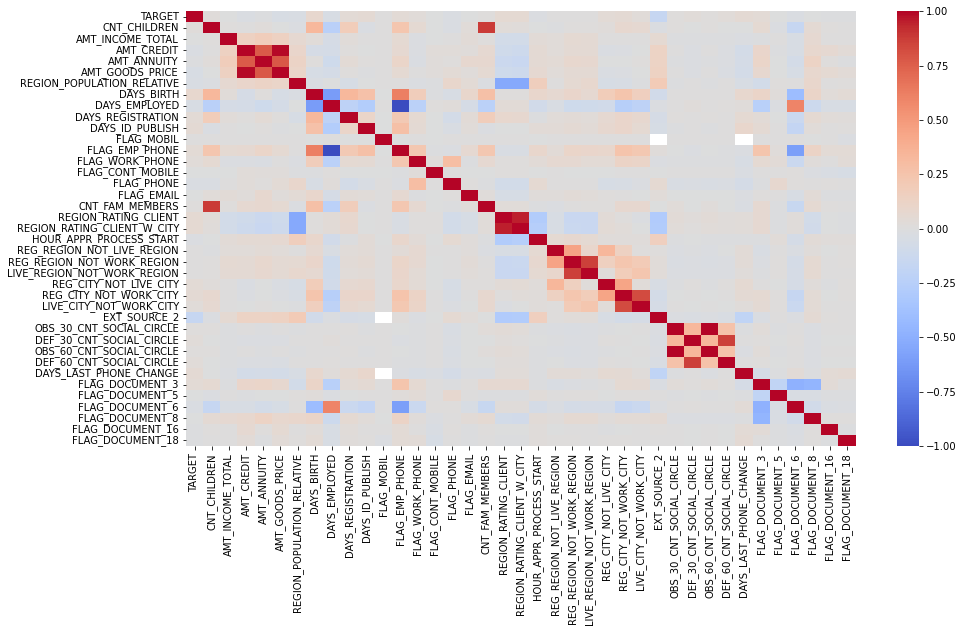

In [20]:
plt.figure(figsize=(15,8))
sns.heatmap(df.drop(['SK_ID_CURR'],axis=1).corr(), cmap='coolwarm',vmin=-1,vmax=1);

- 2.5 Análise univariada de Outliers

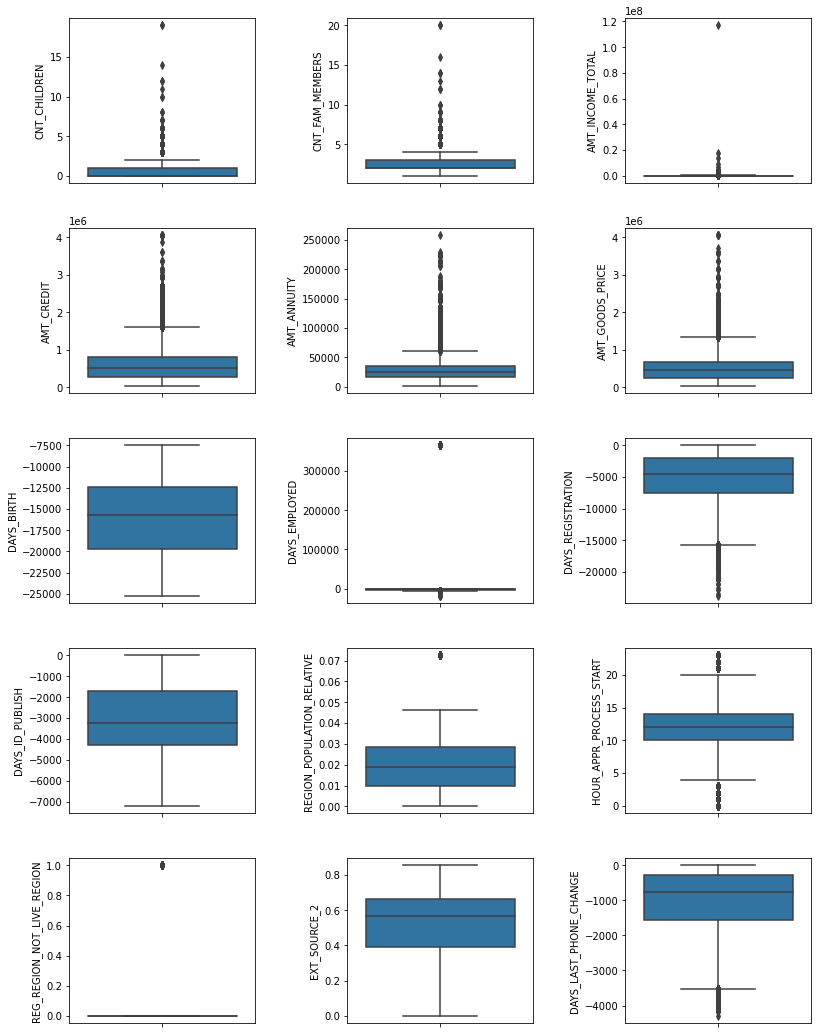

In [23]:
fig, ax = plt.subplots(5, 3, figsize=(12,15))
sns.boxplot(data=df, y='CNT_CHILDREN', ax=ax[0,0])
sns.boxplot(data=df, y='CNT_FAM_MEMBERS', ax=ax[0,1])
sns.boxplot(data=df, y='AMT_INCOME_TOTAL', ax=ax[0,2])
sns.boxplot(data=df, y='AMT_CREDIT', ax=ax[1,0])
sns.boxplot(data=df, y='AMT_ANNUITY', ax=ax[1,1])
sns.boxplot(data=df, y='AMT_GOODS_PRICE', ax=ax[1,2])
sns.boxplot(data=df, y='DAYS_BIRTH', ax=ax[2,0])
sns.boxplot(data=df, y='DAYS_EMPLOYED', ax=ax[2,1])
sns.boxplot(data=df, y='DAYS_REGISTRATION', ax=ax[2,2])
sns.boxplot(data=df, y='DAYS_ID_PUBLISH', ax=ax[3,0])
sns.boxplot(data=df, y='REGION_POPULATION_RELATIVE', ax=ax[3,1])
sns.boxplot(data=df, y='HOUR_APPR_PROCESS_START', ax=ax[3,2])
sns.boxplot(data=df, y='REG_REGION_NOT_LIVE_REGION', ax=ax[4,0])
sns.boxplot(data=df, y='EXT_SOURCE_2', ax=ax[4,1])
sns.boxplot(data=df, y='DAYS_LAST_PHONE_CHANGE', ax=ax[4,2])
fig.tight_layout(pad=3)  # distância entre cada gráfico

- 2.6 Relação das possíveis variáveis explicativas com a com a target 

In [24]:
# variáveis de classe (agregações)
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_CONTRACT_TYPE',  aggfunc={'TARGET': 'mean' , 'NAME_CONTRACT_TYPE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'CODE_GENDER',  aggfunc={'TARGET': 'mean' , 'CODE_GENDER': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_OWN_CAR',  aggfunc={'TARGET': 'mean' , 'FLAG_OWN_CAR': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_OWN_REALTY',  aggfunc={'TARGET': 'mean' , 'FLAG_OWN_REALTY': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_TYPE_SUITE',  aggfunc={'TARGET': 'mean' , 'NAME_TYPE_SUITE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_INCOME_TYPE',  aggfunc={'TARGET': 'mean' , 'NAME_INCOME_TYPE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_EDUCATION_TYPE',  aggfunc={'TARGET': 'mean' , 'NAME_EDUCATION_TYPE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_FAMILY_STATUS',  aggfunc={'TARGET': 'mean' , 'NAME_FAMILY_STATUS': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'NAME_HOUSING_TYPE',  aggfunc={'TARGET': 'mean' , 'NAME_HOUSING_TYPE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_EMP_PHONE',  aggfunc={'TARGET': 'mean' , 'FLAG_EMP_PHONE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_WORK_PHONE',  aggfunc={'TARGET': 'mean' , 'FLAG_WORK_PHONE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_CONT_MOBILE',  aggfunc={'TARGET': 'mean' , 'FLAG_CONT_MOBILE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_EMP_PHONE',  aggfunc={'TARGET': 'mean' , 'FLAG_EMP_PHONE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_PHONE',  aggfunc={'TARGET': 'mean' , 'FLAG_PHONE': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'FLAG_EMAIL',  aggfunc={'TARGET': 'mean' , 'FLAG_EMAIL': 'count'}),"\n")
print(pd.pivot_table(data = df, values ='TARGET', index = 'WEEKDAY_APPR_PROCESS_START',  aggfunc={'TARGET': 'mean' , 'WEEKDAY_APPR_PROCESS_START': 'count'}),"\n")

                    NAME_CONTRACT_TYPE    TARGET
NAME_CONTRACT_TYPE                              
Cash loans                      222622  0.083932
Revolving loans                  23382  0.054957 

             CODE_GENDER    TARGET
CODE_GENDER                       
F                 161866  0.070305
M                  84138  0.102094 

              FLAG_OWN_CAR    TARGET
FLAG_OWN_CAR                        
N                   162353  0.085628
Y                    83651  0.072539 

                 FLAG_OWN_REALTY    TARGET
FLAG_OWN_REALTY                           
N                          75473  0.083858
Y                         170531  0.079991 

                 NAME_TYPE_SUITE    TARGET
NAME_TYPE_SUITE                           
Children                    2614  0.078806
Family                     32145  0.074724
Group of people              217  0.096774
Other_A                      689  0.088534
Other_B                     1448  0.098757
Spouse, partner             9121  0

### 3.Train x Test Split

In [47]:
df_treino, df_teste = train_test_split(df, test_size = 0.3, random_state = 10)

In [48]:
# Teste de código para pipeline de pré-processamento

var_resp = 'TARGET'

var_string_binaria = ['CODE_GENDER','FLAG_OWN_REALTY','NAME_CONTRACT_TYPE','FLAG_OWN_CAR']
var_string_nao_binaria = ['NAME_EDUCATION_TYPE','NAME_HOUSING_TYPE','NAME_INCOME_TYPE']
var_string = var_string_binaria + var_string_nao_binaria

var_num_discretas = ['CNT_CHILDREN','DEF_30_CNT_SOCIAL_CIRCLE','REGION_RATING_CLIENT']
var_num_continuas = ['AMT_INCOME_TOTAL','DAYS_REGISTRATION','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE','EXT_SOURCE_2','REGION_POPULATION_RELATIVE']

var_num_flag = ['FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_18'] 


var_num = var_num_discretas + var_num_continuas + var_num_flag
var_num_sem_flag = var_num_discretas + var_num_continuas

var_expl = var_num + var_string

In [49]:
x_treino = df_treino[var_expl].copy()
x_teste = df_teste[var_expl].copy()
y_treino = df_treino[var_resp].copy()
y_teste = df_teste[var_resp].copy()

### 4. Pré-processamento

- 4.0 Simple Imputer

In [50]:
simple_imputer = SimpleImputer()

imputer_num  = SimpleImputer(missing_values = np.nan , strategy = 'mean')
imputer_flag = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
imputer_str  = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')

x_treino[var_num_sem_flag ] = imputer_num.fit_transform(x_treino[var_num_sem_flag])
x_treino[var_num_flag] = imputer_flag.fit_transform(x_treino[var_num_flag])
x_treino[var_string  ] = imputer_str.fit_transform(x_treino[var_string])

x_teste[var_num_sem_flag ] = imputer_num.transform(x_teste[var_num_sem_flag ])
x_teste[var_num_flag] = imputer_flag.transform(x_teste[var_num_flag])
x_teste[var_string  ] = imputer_str.transform(x_teste[var_string])

* 4.1- Label Encoder

In [51]:
label_encoder = LabelEncoder()

- 4.2- Ordinal Encoder

In [52]:
lista_ordenada_NAME_EDUCATION_TYPE = [
    
    'Lower secondary',
    'Secondary / secondary special', 
    'Incomplete higher',
    'Higher education', 
    'Academic degree' 
]

oe_NAME_EDUCATION_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_EDUCATION_TYPE])

x_treino[['NAME_EDUCATION_TYPE']] = oe_NAME_EDUCATION_TYPE.fit_transform(x_treino[['NAME_EDUCATION_TYPE']])
x_teste[['NAME_EDUCATION_TYPE']] = oe_NAME_EDUCATION_TYPE.transform(x_teste[['NAME_EDUCATION_TYPE']])

In [53]:
lista_ordenada_NAME_HOUSING_TYPE = [
    
    'With parents',
    'Municipal apartment',
    'Co-op apartment',
    'Rented apartment',
    'Office apartment',
    'House / apartment'
]

oe_NAME_HOUSING_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_HOUSING_TYPE])

x_treino[['NAME_HOUSING_TYPE']] = oe_NAME_HOUSING_TYPE.fit_transform(x_treino[['NAME_HOUSING_TYPE']])
x_teste[['NAME_HOUSING_TYPE']] = oe_NAME_HOUSING_TYPE.transform(x_teste[['NAME_HOUSING_TYPE']])

In [54]:
lista_ordenada_NAME_INCOME_TYPE = [

'Unemployed',
'Student',
'Maternity leave',
'Pensioner',
'Working',
'Commercial associate',
'Businessman',            
'State servant'
    
]

oe_NAME_INCOME_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_INCOME_TYPE])

x_treino[['NAME_INCOME_TYPE']] = oe_NAME_INCOME_TYPE.fit_transform(x_treino[['NAME_INCOME_TYPE']])
x_teste[['NAME_INCOME_TYPE']] = oe_NAME_INCOME_TYPE.transform(x_teste[['NAME_INCOME_TYPE']])

- 4.3- One Hot Encoder

In [55]:
ohe = OneHotEncoder(drop='first',sparse=False)
x_treino[var_string_binaria] = ohe.fit_transform(x_treino[var_string_binaria])
x_teste[var_string_binaria] = ohe.transform(x_teste[var_string_binaria])

- 4.4- Normalizações Std

In [56]:
scaler = StandardScaler()
x_treino[var_num_sem_flag ] = scaler.fit_transform(x_treino[var_num_sem_flag])
x_teste[var_num_sem_flag ] = scaler.transform(x_teste[var_num_sem_flag])

- 4.5 Column trasnformer

In [57]:
t= [('imp_miss_num', imputer_num , var_num_sem_flag)]
preproc_t = ColumnTransformer(transformers=t, remainder='passthrough')

### 5. Feature Selection

5.0 Seleção univariada

In [76]:
skb = SelectKBest( k = 25)
skb.fit(x_treino, y_treino);

In [77]:
print("Scores:", skb.scores_,"\n") 
print("Features:",skb.get_feature_names_out())

Scores: [6.83627423e+01 1.36800251e+02 5.59937485e+02 4.24914490e-02
 2.86768036e+02 1.75226190e+02 3.35323355e+01 2.90209658e+02
 4.69472421e+02 4.96470884e+02 4.39160739e+03 1.97544045e+02
 3.78262118e+02 1.32671570e+02 3.32728024e+02 1.11947687e+00
 1.33719759e+02 1.31783281e+01 1.99997539e+01 1.43911522e+01
 4.90019337e+02 5.59204511e+00 1.47522294e+02 9.26950025e+01
 5.56711242e+02 1.53896370e+02 4.17569629e+00] 

Features: ['CNT_CHILDREN' 'DEF_30_CNT_SOCIAL_CIRCLE' 'REGION_RATING_CLIENT'
 'DAYS_REGISTRATION' 'AMT_CREDIT' 'AMT_ANNUITY' 'AMT_GOODS_PRICE'
 'DAYS_ID_PUBLISH' 'DAYS_LAST_PHONE_CHANGE' 'EXT_SOURCE_2'
 'REGION_POPULATION_RELATIVE' 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE'
 'FLAG_DOCUMENT_3' 'FLAG_DOCUMENT_6' 'FLAG_DOCUMENT_8' 'FLAG_DOCUMENT_16'
 'FLAG_DOCUMENT_18' 'CODE_GENDER' 'FLAG_OWN_REALTY' 'NAME_CONTRACT_TYPE'
 'FLAG_OWN_CAR' 'NAME_EDUCATION_TYPE' 'NAME_HOUSING_TYPE'
 'NAME_INCOME_TYPE']


5.1 Testes de modelagem com árvores de decisão simples

In [78]:
%%time

# Escolha de Variáveis
x_treino2 = x_treino[skb.get_feature_names_out()]
x_teste2 = x_teste[skb.get_feature_names_out()]

modelo = DecisionTreeClassifier(
    max_depth = 7,
    max_leaf_nodes= 80,
    random_state = 10    
)

modelo.fit(x_treino2, y_treino)

y_pred_treino = modelo.predict_proba(x_treino2)[:, 1]
y_pred_teste = modelo.predict_proba(x_teste2)[:, 1]

roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste)

CPU times: total: 1.14 s
Wall time: 1.21 s


(0.6853506323456551, 0.6813428089408122)

5.2 Testes de modelagem com Adaboost

In [90]:
%%time

# Escolha de Variáveis
x_treino2 = x_treino[skb.get_feature_names_out()]
x_teste2 = x_teste[skb.get_feature_names_out()]

modelo = AdaBoostClassifier(    
    n_estimators = 100,
    learning_rate = 0.2,
    random_state = 1    
)

modelo.fit(x_treino2, y_treino)

y_pred_treino = modelo.predict_proba(x_treino2)[:, 1]
y_pred_teste = modelo.predict_proba(x_teste2)[:, 1]

roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste)

CPU times: total: 26.3 s
Wall time: 26.7 s


(0.7007723846937164, 0.7082397439477165)

5.3 Testes de modelagem com XGBOOST

In [88]:
%%time

# Escolha de Variáveis
x_treino2 = x_treino[skb.get_feature_names_out()]
x_teste2 = x_teste[skb.get_feature_names_out()]

modelo = xgb.XGBClassifier(    
    n_estimators = 100,
    eta = 0.1,
    n_jobs= 16,
    random_state = 1    
)

modelo.fit(x_treino2, y_treino)

y_pred_treino = modelo.predict_proba(x_treino2)[:, 1]
y_pred_teste = modelo.predict_proba(x_teste2)[:, 1]

roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste)

CPU times: total: 50.3 s
Wall time: 13.1 s


(0.7710950911233849, 0.7182204950192328)

### 6.Otimização de hiperparâmetros

In [ ]:
# Escolha de Variáveis
x_treino2 = x_treino[skb.get_feature_names_out()]
x_teste2 = x_teste[skb.get_feature_names_out()]

6.0 - Adaboost

In [419]:
%%time

parametros = {
    'n_estimators': [100, 250,500],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5]
}

modelo = AdaBoostClassifier(
    random_state = 1    
)

gscv = GridSearchCV(
    estimator = modelo,
    param_grid = parametros,
    scoring = 'roc_auc',
    refit = True,
    cv = 3
)

gscv.fit(x_treino2, y_treino)

y_pred_treino = gscv.predict_proba(x_treino2)[:, 1]
y_pred_teste = gscv.predict_proba(x_teste2)[:, 1]

print(roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste))
print(gscv.best_params_)

0.713202836929204 0.7145657023238283
{'learning_rate': 0.5, 'n_estimators': 500}
CPU times: total: 32min 55s
Wall time: 33min 43s


6.1 - Árvore de decisão (simples)

In [667]:
%%time

parametros = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'max_leaf_nodes':[6,8,10,12,20,40,60,80,100]
}

modelo = DecisionTreeClassifier(
    random_state = 10    
)

gscv = GridSearchCV(
    estimator = modelo,
    param_grid = parametros,
    scoring = 'roc_auc',
    refit = True,
    cv = 3
)

gscv.fit(x_treino2, y_treino)

y_pred_treino = gscv.predict_proba(x_treino2)[:, 1]
y_pred_teste = gscv.predict_proba(x_teste2)[:, 1]

print(roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste))
print(gscv.best_params_)

0.6848792200912232 0.6806094533096149
{'max_depth': 7, 'max_leaf_nodes': 80}
CPU times: total: 2min 7s
Wall time: 2min 9s


6.2 - Random Forrest

In [691]:
%%time

parametros = {
    'max_depth': [10,20,50,100],
    'n_estimators': [50,100,200,500]
}

modelo = RandomForestClassifier( 
    random_state = 1    
)

gscv = GridSearchCV(
    estimator = modelo,
    param_grid = parametros,
    scoring = 'roc_auc',
    refit = True,
    cv = 3
)

gscv.fit(x_treino2, y_treino)

y_pred_treino = gscv.predict_proba(x_treino2)[:, 1]
y_pred_teste = gscv.predict_proba(x_teste2)[:, 1]

print(roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste))
print(gscv.best_params_)

0.7977415246887106 0.7097086745134122
{'max_depth': 10, 'n_estimators': 500}
CPU times: total: 37min 43s
Wall time: 38min 11s


6.3 - XGBosst

In [93]:
%%time

parametros = {
    'max_depth': [5,25],
    #'max_leaves': [20,50,100],
    'learning_rate': [0.05,0.1,0.2],
    #'booster': ['gbtree', 'gblinear','dart'],
    'lambda': [0.5,1,1.5]
}

modelo = xgb.XGBClassifier( 
    random_state = 1,
    n_jobs = 16
)

gscv = GridSearchCV(
    estimator = modelo,
    param_grid = parametros,
    scoring = 'roc_auc',
    refit = True,
    cv = 3
)

gscv.fit(x_treino2, y_treino)

y_pred_treino = gscv.predict_proba(x_treino2)[:, 1]
y_pred_teste = gscv.predict_proba(x_teste2)[:, 1]

print(roc_auc_score(y_treino, y_pred_treino) , roc_auc_score(y_teste, y_pred_teste))
print(gscv.best_params_)

0.7710043303526277 0.7159248917038681
{'lambda': 1.5, 'learning_rate': 0.2, 'max_depth': 5}
CPU times: total: 1h 38min 5s
Wall time: 28min 53s


### 8. Aplicação do melhor modelo com Pipelines

- 8.0 Listas ordenadas

In [736]:
lista_ordenada_NAME_EDUCATION_TYPE = [
    
    'Lower secondary',
    'Secondary / secondary special', 
    'Incomplete higher',
    'Higher education', 
    'Academic degree' 
]
oe_NAME_EDUCATION_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_EDUCATION_TYPE])

lista_ordenada_NAME_HOUSING_TYPE = [
    
    'With parents',
    'Municipal apartment',
    'Co-op apartment',
    'Rented apartment',
    'Office apartment',
    'House / apartment'
]
oe_NAME_HOUSING_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_HOUSING_TYPE])

lista_ordenada_NAME_INCOME_TYPE = [

'Unemployed',
'Student',
'Maternity leave',
'Pensioner',
'Working',
'Commercial associate',
'Businessman',            
'State servant'
    
]
oe_NAME_INCOME_TYPE = OrdinalEncoder(categories = [lista_ordenada_NAME_INCOME_TYPE])

- 8.1 Pipelines de pré-processamento e aplicação do modelo

In [737]:
pipeline_imput_num = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

pipeline_input_flg = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first',sparse=False))
])

pipeline_NAME_EDUCATION_TYPE = Pipeline(steps=[
    ('NAME_EDUCATION_TYPE', oe_NAME_EDUCATION_TYPE)    
])

pipeline_NAME_HOUSING_TYPE = Pipeline(steps=[
    ('NAME_HOUSING_TYPE', oe_NAME_HOUSING_TYPE)    
])

pipeline_NAME_INCOME_TYPE = Pipeline(steps=[
    ('NAME_INCOME_TYPE', oe_NAME_INCOME_TYPE)    
])

pipeline_preproc = ColumnTransformer(transformers = [
    ('numericas',            pipeline_imput_num,             var_num_sem_flag        ),
    ('strings',              pipeline_input_flg,             var_string              ),
    ('NAME_EDUCATION_TYPE',  pipeline_NAME_EDUCATION_TYPE,  ['NAME_EDUCATION_TYPE']  ),
    ('NAME_HOUSING_TYPE',    pipeline_NAME_HOUSING_TYPE,    ['NAME_HOUSING_TYPE']    ),
    ('NAME_INCOME_TYPE',     pipeline_NAME_INCOME_TYPE,     ['NAME_INCOME_TYPE']     )
])

melhor_modelo = xgb.XGBClassifier(    
    n_estimators = 100,
    eta = 0.1,
    n_jobs= 16,
    random_state = 1    
)

pipeline_final =  Pipeline(steps=[('preproc_modelo', pipeline_preproc) , ('melhor_modelo', melhor_modelo)])

- 8.2 Ajuste e aplicação do melhor modelo

In [755]:
pipeline_final.fit(x_treino,y_treino)
y_pred_treino_melhor_modelo = pipeline_final.predict_proba(x_treino)[:, 1]
y_pred_teste_melhor_modelo = pipeline_final.predict_proba(x_teste)[:, 1]
roc_auc_score(y_treino, y_pred_treino_melhor_modelo) , roc_auc_score(y_teste, y_pred_teste_melhor_modelo)

(0.7133585708711734, 0.7141992213720487)

### 9. Previsão e Export

- 9.0 - Adaptando a base de previsão (df_oculto) com tratamentos gerais

In [753]:
df_oculto = df_oculto[df_oculto['CODE_GENDER'] != 'XNA']
df_oculto = df_oculto[df_oculto['NAME_FAMILY_STATUS'] != 'Unknown']

- 9.1 - Export dos resultados para arquivo csv

In [752]:
df_oculto['Y_PRED'] = pipeline_final.predict_proba(df_oculto)[:, 1]
df_oculto[['SK_ID_CURR','Y_PRED']].to_csv('previsao_credito_equipe4_MLII.csv', index=False)